# 2018-06-05 Deconvolution and FRC with a theoretical PSF (not converging)

In [here](http://localhost:8888/notebooks/notebooks/2018-06%20-%20Deconvolution%20with%20Consecutive%20Deconvolution%20estimates.ipynb) and here I demonstrated that applying FRC to deconvolution results is rather challenging, as the deconvolution process make cause for the two images to strongly correlate. Here I show how the deconvolution results can be successfully evaluated with FRC using the checkerboard split method.

Also because the point-spread-function does not properly fit the data, here I see how such non-optimal convergence is reflected in the FRC measurments and deconvolution results. 

In [1]:
%matplotlib inline

import os
import numpy as np

from supertomo.data.io import carma
import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.processing.deconvolution import deconvolve
from supertomo.data.messages import image_writer_wrappers as imwrap
import supertomo.data.io.read as imread
import supertomo.processing.image as imops
from supertomo.data.containers.image import Image


## Load an image

The image is from a Nikon A1 confocal system, of a Tubulin stained HeLa cell. There is a zero offset in the image, which I correct here, to make the devonvolution behave nicely. 

In [2]:
# Image
data_dir = "/Users/sami/Temp"
filename = "FRC_GaAsP_AU04__.nd2"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path)

spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

image = Image(image - image.min(), image.spacing)
image_copy = Image(image.copy(), image.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


## Generate a PSF

A theoretical PSF is generated according to the instrument properties. 

In [3]:

def get_confocal_psf(ndim, ex_wavelen=488, em_wavelen=550, na=1.4, refr_index=1.5, 
                     pinhole=.4, magnification=60, sted=False):


    psf = psfgen.PSF(psfgen.GAUSSIAN | psfgen.CONFOCAL, shape=(128,128), ex_wavelen=ex_wavelen, 
                          em_wavelen=em_wavelen, num_aperture=na, refr_index=refr_index, 
                          pinhole_radius=pinhole, magnification=magnification )
    if sted:
        psf.sted_correction()
        
    psf_image = psf.volume()
    psf_spacing = (psf.dims['um'][0]/psf.shape[0],)*3

    if ndim == 2:
        psf_image = psf_image[psf_image.shape[0]/2]
        psf_spacing = psf_spacing[:-1]

    return Image(psf_image, psf_spacing)

psf = get_confocal_psf(2)

print "Succesfully generated a theoretical PSF."
print "The image dimensions are {} and spacing {}.".format(psf.shape, psf.spacing)

Succesfully generated a theoretical PSF.
The image dimensions are (255, 255) and spacing [0.03125, 0.03125].


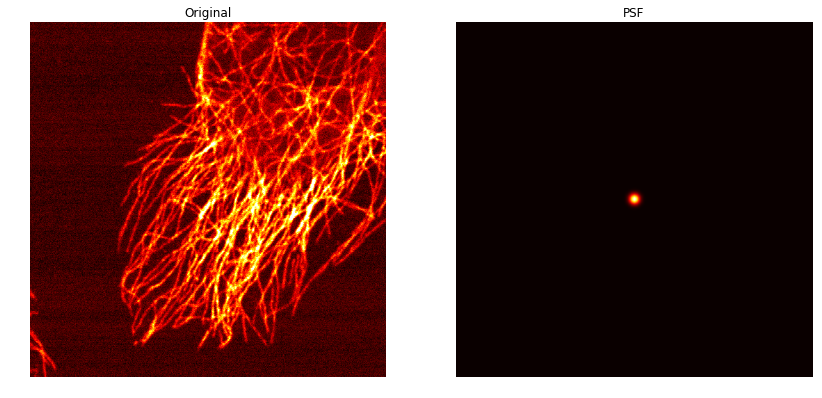

In [4]:
showim.display_2d_images(imops.enhance_contrast(image, percent_saturated=0.3), 
                         psf,
                         image1_title="Original",
                         image2_title="PSF")



## Run deconvolution

Having generated the PSF, deconvolution is now run for 60 iterations. No stopping condition is used, because I wanted to evaluate the performance of the various parameters later on. For later FRC analysis, the intermediate results are saved on the disk.

In [5]:
from supertomo.ui import deconvolution_options as options
n_iterations = 45
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=half-bit").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

In [6]:
from scipy.ndimage import gaussian_filter

#psf = Image(gaussian_filter(psf), psf.spacing)
temp_data_dir = os.path.join(data_dir, "theoretical")
if not os.path.exists(temp_data_dir):
    os.mkdir(temp_data_dir)
    
writer = imwrap.TiffImageWriter(temp_data_dir)

task = deconvolve.DeconvolutionRL(image, psf, writer, args)
task.execute()

The original image size is (512, 512)
The deconvolution will be run with 1 blocks
The internal block size is (512, 512)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/45                ] E/S/U/N=0/21205586/14132859/0, LEAK=-0.706315669649%, TAU1=0.0512556992471, TIME=0.167s, U/ESU=0.400 

/Users/sami/anaconda/envs/supertomo2/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



Beginning the computation of the 1. estimate
[=>                2/45                ] ETA:6.5s E/S/U/N=0/26892332/8473947/0, LEAK=-0.785636573402%, TAU1=0.0344233028591, TIME=0.146s, U/ESU=0.240 
Beginning the computation of the 2. estimate
[==>               3/45                ] ETA:6.5s E/S/U/N=361/29932279/5426690/0, LEAK=-0.765833845599%, TAU1=0.027366137132, TIME=0.148s, U/ESU=0.153 
Beginning the computation of the 3. estimate
[==>               4/45                ] ETA:6.5s E/S/U/N=0/31479824/3868205/0, LEAK=-0.733626731442%, TAU1=0.0233399868011, TIME=0.156s, U/ESU=0.109 
Beginning the computation of the 4. estimate
[===>             5/45                 ] ETA:6.2s E/S/U/N=0/32435735/2902211/0, LEAK=-0.704893661446%, TAU1=0.0206931810826, TIME=0.141s, U/ESU=8.21E-2 
Beginning the computation of the 5. estimate
[====>            6/45                 ] ETA:6.0s E/S/U/N=85/33167809/2161517/0, LEAK=-0.680571532882%, TAU1=0.0187683906406, TIME=0.148s, U/ESU=6.12E-2 
Beginning the

[=================43/45=============>  ] ETA:317ms E/S/U/N=376/35248901/26898/0, LEAK=-0.528861164504%, TAU1=0.00759271718562, TIME=0.144s, U/ESU=7.63E-4 
Beginning the computation of the 43. estimate
[=================44/45==============> ] ETA:159ms E/S/U/N=0/35250392/25963/0, LEAK=-0.529371664611%, TAU1=0.00753182172775, TIME=0.165s, U/ESU=7.36E-4 
Beginning the computation of the 44. estimate
[================45/45=================] ETA:0 E/S/U/N=97/35251657/24802/0, LEAK=-0.529945900379%, TAU1=0.00747382687405, TIME=0.150s, U/ESU=7.03E-4 
Nothing happens

[================45/45=================] ETA:0 The number of iterations reached to maximal count: 45 


## Results

It is evident that 60 iterations are excessive. It is also evident that while the details are smaller than in the original image dthe deconvolution has resulted into strong amplification and fitting of noise, especially in the internal aprt of the cell with a lot of overlapping low-contrast structures. In some places the image details con not almost be distinquished from the noise. The PSF clearly was not ideal.

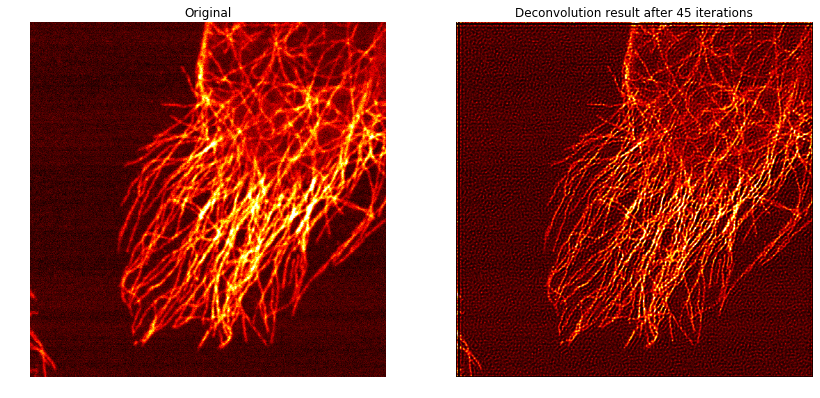

In [7]:
result = task.get_result()

showim.display_2d_images(imops.enhance_contrast(image, percent_saturated=0.3), 
                         imops.enhance_contrast(result, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="Deconvolution result after {} iterations".format(n_iterations))




## FRC analysis of the deconvolution progress

Here I analyse each of the intermediate results from the deconvolution with FRC. 

In [8]:
import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations):
    image_name = "result_{}.tif".format(idx)

    image_path = os.path.join(temp_data_dir, image_name)

    image = read.get_image(image_path)
    image1, image2 = imops.checkerboard_split(image)
    
    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0]*sqrt(2), args)
results = analyzer.execute()


Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000056
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000048
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000039
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.6640625
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.6640625
Opti

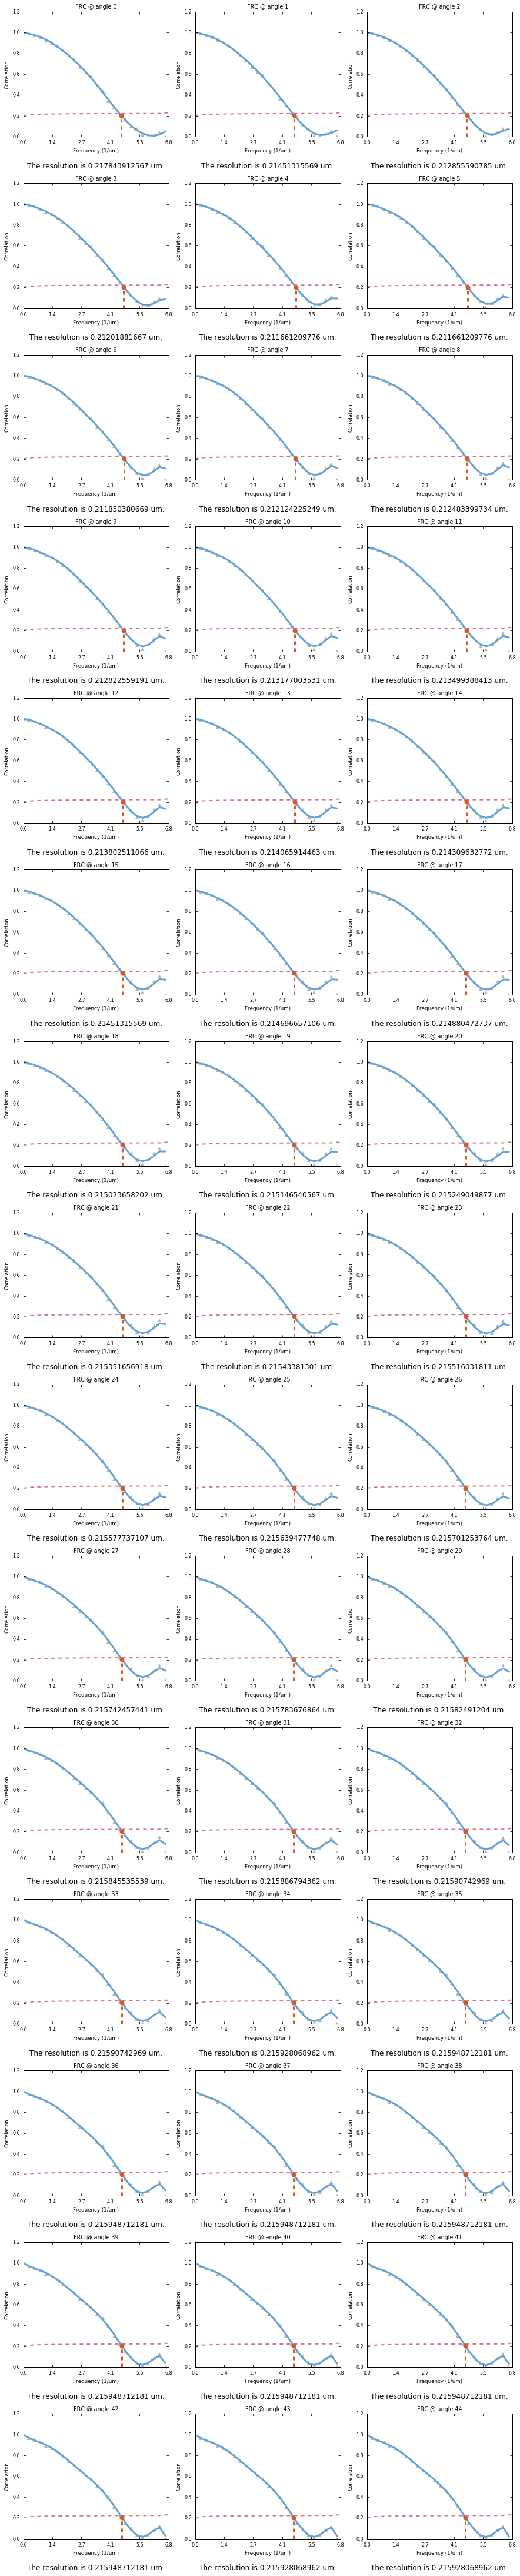

In [9]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

## Regarding the measured FRC values

I wanted to see look more closely into how the FRC values behave as a function of the iteration count. The *SuperTomo* deconvolution algorithm also calculates several parameter values that have traditionally been used to evaluate the progress of an iterative deconvolution. For more info, look at (Koho et al 2014). 

Here I normalize all the parameter values (0-1) for easy comparison and plotting. The original values are maintained in the *deconvolution_parameters* dataframe.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1cac8c31d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1cacd4ed10>], dtype=object)

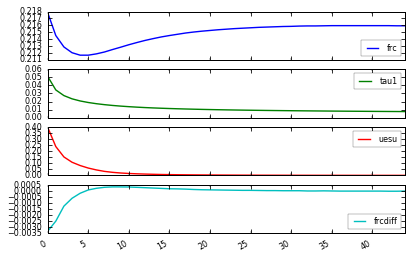

In [17]:
# Get a list of the resolution values as a function of iteration number
iterations = list()
resolutions = list()

for dataset in results:
    iterations.append(int(dataset[0]))
    resolutions.append(dataset[1].resolution["resolution"])

iterations, resolutions = zip(*sorted(zip(iterations, resolutions)))

# Get saved deconvolution parameters
deconvolution_parameters = task.progress_parameters
deconvolution_parameters['frc'] = resolutions


# Set up curves
curves = deconvolution_parameters.loc[:, ['frc', 'tau1', 'uesu']]

curves['frcdiff'] = np.gradient(curves['frc'])

curves.plot(subplots=True)

directory = "/Users/sami/Documents/Work/Article manuscripts/2018_FRC:FSC/Data/Figure_FRC_Deconvolution/RL_Not_Converging"

plotter = frcplots.FourierDataPlotter(results, directory)
#plotter.plot_all()

plotter.plot_one_to_file(4, "frc_5", size=(1.7,1.7))
plotter.plot_one_to_file(19, "frc_20", size=(1.7,1.7))
plotter.plot_one_to_file(29, "frc_30", size=(1.7,1.7))
plotter.plot_one_to_file(34, "frc_35", size=(1.7,1.7))

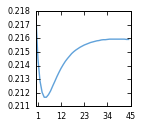

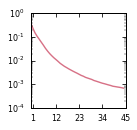

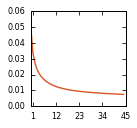

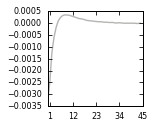

In [18]:
import matplotlib.pyplot as plt

directory = "/Users/sami/Documents/Work/Article manuscripts/2018_FRC:FSC/Data/Figure_FRC_Deconvolution/RL_Not_Converging"



x_ticks = np.linspace(1, n_iterations, num=5, dtype=int)
size = (1.7, 1.7)
frc_plot = curves.plot(y='frc', figsize=size, legend=False, color='#61a2da', xticks=x_ticks)
plt.savefig(os.path.join(directory, "rl_resolution_vs_iteration.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

uesu_plot = curves.plot(y='uesu', figsize=size, legend=False, color='#d77186', xticks=x_ticks, logy=True)
plt.savefig(os.path.join(directory, "rl_uesu_vs_iteration.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

tau1_plot = curves.plot(y='tau1', figsize=size, legend=False, color='#D75725', xticks=x_ticks)
plt.savefig(os.path.join(directory, "rl_tau1_vs_iteration.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

frc_diff_plot = curves.plot(y='frcdiff', figsize=size, legend=False, color='#b5b5b3', xticks=x_ticks)
plt.savefig(os.path.join(directory, "rl_resgrad_vs_iteration.eps"), 
            dpi=1200, bbox_inches='tight', pad_inches=0, transparent=True)

## Regarding the FRC resolution curve

The FRC resolution value curve behaves in a very interestin way. It tells that the highest effective resolution is achieved already after 4 iterations. As we have learned, this indicates that the deconvolution does not converge properly, ast the PSF is not ideal. However a clear improvement in terms of contrast and effective resolution can be seen, when compared with the original image.

In [11]:
zero_crossing = np.where(np.diff(np.sign(curves['frcdiff'])))[0][0]

print "The deconvolution should be stopped at iteration {}.".format(zero_crossing)

The deconvolution should be stopped at iteration 4.


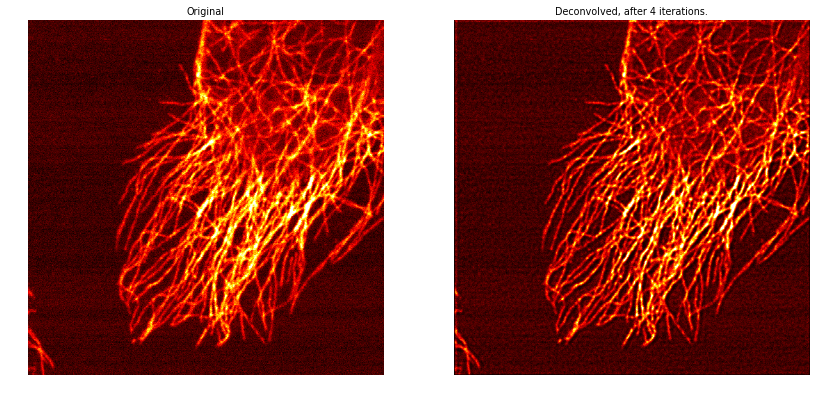

In [12]:
image_path = os.path.join(data_dir, "result_{}.tif".format(zero_crossing))

result_image = read.get_image(image_path)

showim.display_2d_images(imops.enhance_contrast(image_copy, percent_saturated=0.3), 
                         imops.enhance_contrast(result_image, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="Deconvolved, after {} iterations.".format(zero_crossing))




